In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import random
from torchvision.datasets import mnist
import seaborn as sns
import cv2
import time
import torch
from torch import nn
from sklearn.metrics import roc_auc_score, roc_curve, auc
from PIL import Image
from PIL import ImageFile
from skimage.util import random_noise

In [2]:
cnn_channels = 96
num_vec = 16
inSize = int((cnn_channels*6*6)/num_vec*2)
outSize = 1
resSize = 2000
a = 0.3
trainLen = 8192
batch_size_train = 1024
batch_size_test = 1000
one = torch.ones([1,1])
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
np.random.seed(304)
torch.manual_seed(304)

In [4]:
def sigmoid(x):
    s = 1/(1 + torch.exp(-x))
    return s

In [5]:
class PairedDataset(Dataset):
    def __init__(self, imgs, labels):
        self.x = imgs
        self.y = labels
        
    def __len__(self):
        return len(self.x)    
    
    def __getitem__(self, index):
        img0 = self.x[index] / 255
        y0 = self.y[index]
        if np.random.rand() < 0.5:
            idx = np.random.choice(np.arange(len(self.y))[self.y==y0],1)
        else:
            idx = np.random.choice(np.arange(len(self.y))[self.y!=y0],1)
                    
        img1 = self.x[idx[0]] / 255
        y1 = self.y[idx[0]]
        if y0==y1:
            label = 1
        else:
            label = 0
        
        return torch.from_numpy(img0), torch.from_numpy(img1), torch.tensor(label)

In [6]:
train_set = mnist.MNIST('./data', train=True, download=True)
test_set = mnist.MNIST('./data', train=False, download=True)

train_imgs = train_set.data.numpy()
train_labels = train_set.targets.numpy()

test_imgs = test_set.data.numpy()
test_labels = test_set.targets.numpy()

print(train_imgs.shape,  train_labels.shape)

(60000, 28, 28) (60000,)


D:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
train_paired = PairedDataset(train_imgs, train_labels)
test_paired = PairedDataset(test_imgs, test_labels)

In [8]:
train_iter = DataLoader(train_paired, batch_size=batch_size_train, drop_last=True)
test_iter = DataLoader(test_paired, batch_size=batch_size_test, drop_last=True)

In [9]:
def addGaussNoise(data, sigma):
    sigma2 = sigma**2 / (255 ** 2)
    noise = random_noise(data, mode='gaussian', var=sigma2, clip=True)
    return noise

In [10]:
Win = (torch.rand([resSize,1+inSize])-0.5) * 2.4
W = (torch.rand(resSize,resSize)-0.5)
Win[abs(Win) > 0.6] = 0
#W[abs(W) > 0.05] = 0

In [11]:
rhoW = max(abs(torch.linalg.eig(W)[0]))
W *= 1.25 / rhoW
reg = 1e-12

In [12]:
class ReservoirNet(object):
    def __init__(self, inSize, resSize, a, device):
        super(ReservoirNet, self).__init__()
        self.device = device
        self.inSize = inSize
        self.resSize = resSize
        self.a = a
        self.Win = (torch.rand([self.resSize, 1 + self.inSize]).to(self.device) - 0.5) * 2.4
        self.W = (torch.rand(self.resSize, self.resSize).to(self.device) - 0.5)
        self.Win[abs(self.Win) > 0.6] = 0
        self.rhoW = max(abs(torch.linalg.eig(self.W)[0]))
        self.W *= 1.25 / self.rhoW
        self.reg = 1e-12
        self.one = torch.ones([1, 1]).to(self.device)


    def RCPred(self, Wout, RCin):
        T = RCin.size(0)
        X = torch.zeros([1 + self.inSize + self.resSize, T]).to(self.device)
        x = torch.zeros((self.resSize, 1)).to(self.device)
        for t in range(RCin.size(0)):
            u = RCin[t:t + 1, :].T
            x = (1 - self.a) * x + self.a * sigmoid(torch.matmul(self.Win, torch.vstack((self.one, u))) + torch.matmul(self.W, x))
            X[:, t] = torch.vstack((self.one, u, x))[:, 0]

        pred = Wout @ X
        return pred


    def forward(self, data, labels):
        self.U = data
        self.Yt = labels
        self.T = labels.size(0)
        self.X = torch.zeros([1 + self.inSize + self.resSize, self.T]).to(self.device)
        self.x = torch.zeros((self.resSize, 1)).to(self.device)

        for t in range(self.U.size(0)):
            self.u = self.U[t:t + 1, :].T
            self.x = (1 - self.a) * self.x + self.a * sigmoid(
                torch.matmul(self.Win, torch.vstack((self.one, self.u))) + torch.matmul(self.W, self.x))
            self.X[:, t] = torch.vstack((self.one, self.u, self.x))[:, 0]

        self.Wout = torch.matmul(torch.matmul(self.Yt.T, self.X.T),
                                 torch.linalg.inv(
                                     torch.matmul(self.X, self.X.T) + self.reg * torch.eye(1 + self.inSize + self.resSize).to(self.device)))

        return self.Wout

In [15]:
class Siamese2RC(nn.Module):
    def __init__(self, inSize, filters):
        super(Siamese2RC, self).__init__()
        self.inSize = inSize
        self.filter1, self.filter2, self.filter3, self.filter4 = filters

        self.layer1 = nn.Sequential(nn.Conv2d(1, self.filter1, kernel_size=3, bias=False),
                                    nn.PReLU(),
                                    nn.MaxPool2d(3, stride=1))

        self.layer2 = nn.Sequential(nn.Conv2d(self.filter1, self.filter2, kernel_size=3, bias=False),
                                    nn.PReLU(),
                                    nn.AvgPool2d(3, stride=1))

        self.layer3 = nn.Sequential(nn.Conv2d(self.filter2, self.filter3, kernel_size=3, bias=False),
                                    nn.PReLU(),
                                    nn.AvgPool2d(3, stride=2))

        self.layer4 = nn.Sequential(nn.Conv2d(self.filter3, self.filter4, kernel_size=3, bias=False),
                                    nn.PReLU())

    def forward_once(self, x):
        x = x.unsqueeze(1).to(torch.float32)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

    def forward(self, img0, img1):
        img0 = self.forward_once(img0)
        img1 = self.forward_once(img1)

        img0 = img0.view((-1, int(self.inSize / 2)))
        img1 = img1.view((-1, int(self.inSize / 2)))

        out = torch.cat((img0, img1), dim=-1)

        return out

In [16]:
Net2rc = Siamese2RC(inSize, [32,64,96,96])
Rc = ReservoirNet(inSize, resSize, a, DEVICE)

In [17]:
def weight_init(net):
    if isinstance(net, nn.Conv2d):
        nn.init.kaiming_uniform_(net.weight, mode='fan_in', nonlinearity='leaky_relu')

In [18]:
loss = nn.MSELoss().to(DEVICE)
Train_MSE = []
Train_AUC = []
Test_MSE = []
Test_AUC = []

In [22]:
# Original Version: Concatenate all the output of CNN then feed into RC once.
def train(net2rc, rc, train_iter, device):
    print("train on",device)
    net2rc.apply(weight_init)
    net2rc.to(device)
    rc.to(device)
    cuda = next(net2rc.parameters()).device
    start = time.time()
    net2rc.eval()
    with torch.no_grad():
        similarity = torch.zeros((trainLen, 1))
        gt = torch.zeros((trainLen*num_vec))
        labels = torch.zeros((trainLen, 1))
        RCin = torch.zeros((trainLen*num_vec, inSize))
        for times in range(10):
            for i,(img0,img1,label) in enumerate(train_iter):
                img0, img1, label = img0.to(cuda), img1.to(cuda), label.to(cuda)
                RCin[i*batch_size_train*num_vec:(i+1)*batch_size_train*num_vec, :] = net2rc(img0, img1)
                gt[i*batch_size_train*num_vec:(i+1)*batch_size_train*num_vec] = torch.hstack([torch.tensor([label[t] for _ in range(num_vec)]).T for t in range(batch_size_train)]).to(torch.float32)
                if (i+1)*batch_size_train >= trainLen:
                    break
            Wout = rc(RCin, gt)
            pred = RCPred(Wout, RCin)
            for t in range(trainLen):
                similarity[t,:] = torch.mean(pred[t*num_vec:(t+1)*num_vec])
                labels[t,:] = gt[t*num_vec]
            l = loss(similarity, labels.float())
            Train_MSE.append(l.item())
            auc = roc_auc_score(labels.detach().numpy(), 
                                similarity.squeeze().detach().numpy())
            Train_AUC .append(auc)
            print(f'Times: {times+1}, MSE: {l.item():.4f}, AUC: {auc:.4f}')
        time_train = time.time() - start
        print(f'Time cost for training: {time_train:.4f}s')
    
    return Wout

In [23]:
# Update Version 1: divide train data into mini-batchs and calculate Wout_k respectively, the Wout is the average of all Wout_k. 
# Do it 10 times, choose the Wout which have the best performance on test data as the final Wout.
def train(net2rc, rc, train_iter, device):
    print("train on",device)
    net2rc.apply(weight_init)
    net2rc.to(device)
    rc.to(device)
    cuda = next(net2rc.parameters()).device
    start = time.time()
    net2rc.eval()
    with torch.no_grad():
        Wouts = []
        similarity = torch.zeros((10, batch_size_train))
        labels = torch.zeros((10, batch_size_train))
        for times in range(10):
            for i,(img0,img1,label) in enumerate(train_iter):
                img0, img1, label = img0.to(cuda), img1.to(cuda), label.to(cuda)
                RCin = net2rc(img0, img1)
                gt = torch.hstack([torch.tensor([label[t] for _ in range(num_vec)]).T for t in range(batch_size_train)]).to(torch.float32)
                if i == 0:
                    batch_Wout = rc(RCin, gt)
                elif i > 0 and (i+1)*batch_size_train <= trainLen:
                    batch_Wout = batch_Wout + rc(RCin, gt)
                else:
                    break
            Wouts.append(batch_Wout/(trainLen/batch_size_train))
            pred = RCPred(Wouts[times], RCin)
            for t in range(batch_size_train):
                similarity[times,t] = torch.mean(pred[t*num_vec:(t+1)*num_vec])
                labels[times,t] = gt[t*num_vec]
            l = loss(similarity[times,:], labels[times,:].float())
            Train_MSE.append(l.item())
            auc = roc_auc_score(labels[times,:].detach().numpy(), 
                                similarity[times,:].detach().numpy())
            Train_AUC .append(auc)
            print(f'Times: {times+1}, MSE: {l.item():.4f}, AUC: {auc:.4f}')
        maxAUC_idx = Train_AUC.index(max(Train_AUC))
        time_train = time.time() - start
        print(f'Best AUC: {Train_AUC[maxAUC_idx]:.4f} from Weight_{maxAUC_idx}')
        print(f'Time cost for training: {time_train:.4f}s')
    
    return Wouts

In [19]:
# Update Version 2: same as version 1, but combined the fucntion of training and validating.
# And it is able to provide Wouts with both the best train perfomance and validation performance respectively.
def train(net2rc, rc, train_iter, test_iter, device):
    print("train on",device)
    net2rc.apply(weight_init)
    net2rc.to(device)
    net2rc.eval()
    start = time.time()
    with torch.no_grad():
        Wouts = []
        train_simi = torch.zeros((10, batch_size_train)).to(device)
        train_labels = torch.zeros((10, batch_size_train)).to(device)
        test_simi = torch.zeros((10, batch_size_test)).to(device)
        for times in range(10):
            train_start = time.time()
            for i,(img0,img1,label) in enumerate(train_iter):
                img0, img1, label = img0.to(device), img1.to(device), label.to(device)
                RCin = net2rc(img0, img1)
                gt = torch.hstack([torch.tensor([label[t] for _ in range(num_vec)]).T for t in range(batch_size_train)]).to(torch.float32).to(device)
                if i == 0:
                    batch_Wout = rc.forward(RCin, gt)
                elif i > 0 and (i+1)*batch_size_train <= trainLen:
                    batch_Wout = batch_Wout + rc.forward(RCin, gt)
                else:
                    break
            Wouts.append(batch_Wout/(trainLen/batch_size_train))
            pred = rc.RCPred(Wouts[times], RCin)
            for t in range(batch_size_train):
                train_simi[times,t] = torch.mean(pred[t*num_vec:(t+1)*num_vec])
                train_labels[times,t] = gt[t*num_vec]
            l = loss(train_simi[times,:], train_labels[times,:].float())
            Train_MSE.append(l.item())
            auc = roc_auc_score(train_labels[times,:].detach().cpu().numpy(), 
                                train_simi[times,:].detach().cpu().numpy())
            Train_AUC .append(auc)
            train_end = time.time() - train_start
            print('================================')
            print(f'Time cost for training: {train_end:.4f}s')
            batch_MSE = []
            batch_AUC = []
            test_start = time.time()
            for i,(img0,img1,label) in enumerate(test_iter):
                img0, img1, label = img0.to(device), img1.to(device), label.to(device)
                RCin = net2rc(img0, img1)
                pred = rc.RCPred(Wouts[times], RCin)
                for t in range(batch_size_test):
                    test_simi[times, t] = torch.mean(pred[t*num_vec:(t+1)*num_vec])
                l = loss(test_simi[times], label.float())
                batch_MSE.append(l.item())
                auc = roc_auc_score(label.detach().cpu().numpy(), 
                                    test_simi[times,:].detach().cpu().numpy())
                batch_AUC.append(auc)
            Test_MSE.append(np.mean(batch_MSE))
            Test_AUC.append(np.mean(batch_AUC))
            test_end = time.time() - test_start
            print(f'Times: {times+1}, Train MSE: {Train_MSE[times]:.4f}, Train AUC: {Train_AUC[times]:.4f}')
            print(f'Times: {times+1}, Test MSE: {Test_MSE[times]:.4f}, Test AUC: {Test_AUC[times]:.4f}')
            print(f'Time cost for testing: {test_end:.4f}s')
        trainAUC_idx = Train_AUC.index(max(Train_AUC))
        testAUC_idx = Test_AUC.index(max(Test_AUC))
        total_cost = time.time() - start
        torch.save(net2rc.state_dict(),f'./result/Ver2/Siamese_{inSize}.pth')
        print(f'Best train AUC: {Train_AUC[trainAUC_idx]:.4f} from Weight {trainAUC_idx}')
        print(f'Best test AUC: {Test_AUC[testAUC_idx]:.4f} from Weight {testAUC_idx}')
        print(f'Total cost for 10 times training and testing: {total_cost:.4f}s')
        Wout = Wouts[testAUC_idx]
        np.save(f'./result/Ver2/Wouts_{trainLen}_{batch_size_train}_{resSize}.npy', Wout.detach().numpy())
    
    return Wouts, Wout

In [20]:
Wouts, Wout = train(net2rc, rc, train_iter, test_iter, device)

train on cpu
Time cost for training: 89.6583s
Times: 1, Train MSE: 0.1415, Train AUC: 0.9009
Times: 1, Test MSE: 0.1376, Test AUC: 0.9078
Time cost for testing: 82.3039s
Time cost for training: 89.9918s
Times: 2, Train MSE: 0.1348, Train AUC: 0.9186
Times: 2, Test MSE: 0.1387, Test AUC: 0.9065
Time cost for testing: 79.7072s
Time cost for training: 88.7949s
Times: 3, Train MSE: 0.1416, Train AUC: 0.9008
Times: 3, Test MSE: 0.1365, Test AUC: 0.9098
Time cost for testing: 79.8557s
Time cost for training: 89.0375s
Times: 4, Train MSE: 0.1417, Train AUC: 0.9021
Times: 4, Test MSE: 0.1381, Test AUC: 0.9084
Time cost for testing: 80.8483s
Time cost for training: 89.6659s
Times: 5, Train MSE: 0.1491, Train AUC: 0.8869
Times: 5, Test MSE: 0.1386, Test AUC: 0.9062
Time cost for testing: 82.1283s
Time cost for training: 88.1606s
Times: 6, Train MSE: 0.1440, Train AUC: 0.8945
Times: 6, Test MSE: 0.1379, Test AUC: 0.9080
Time cost for testing: 78.5713s
Time cost for training: 87.2434s
Times: 7, Tr

In [28]:
torch.save(net2rc.state_dict(),f'./result/Siamese_new.pth')
np.save(f'./result/Wouts_{trainLen}_{batch_size_train}_{resSize}.npy', Wouts.detach().numpy())

In [21]:
print(np.mean(Train_MSE))
print(np.mean(Train_AUC))

0.12097075879573822
0.9418529218091869


In [19]:
MSE = []
AUC = []

In [20]:
def calculate_simi(model, test_iter, Wout, device):
    print("test on",device)
    model.to(device)
    cuda = next(model.parameters()).device
    start = time.time()
    model.eval()
    with torch.no_grad():
        similarity = torch.zeros((10000))
        labels = torch.zeros((10000))
        for i,(img0,img1,label) in enumerate(test_iter):
            img0, img1, label = img0.to(cuda), img1.to(cuda), label.to(cuda)
            labels[i*batch_size_test:(i+1)*batch_size_test] = label
            if i == 0:
                example0 = torch.hstack([img0[t] for t in range(10)])
                example1 = torch.hstack([img1[t] for t in range(10)])
                example = torch.cat((example0,example1),dim=0)
            RCin = model(img0, img1)
            pred = RCPred(Wout, RCin)
            for t in range(batch_size_test):
                similarity[i*batch_size_test+t] = torch.mean(pred[t*num_vec:(t+1)*num_vec])
            l = loss(similarity[i*batch_size_test:(i+1)*batch_size_test], label.float())
            MSE.append(l.item())
            auc = roc_auc_score(label.detach().numpy(), 
                                similarity[i*batch_size_test:(i+1)*batch_size_test].detach().numpy())
            AUC .append(auc)
            print(f'Batch: {i+1}, MSE: {l.item():.4f}, AUC: {auc:.4f}')
    time_test = time.time() - start
    print(f'Time cost for testing: {time_test:.4f}s')
    
    return similarity, example, labels

In [22]:
Wout = torch.from_numpy(np.load('./result/train/weights/Wout_60000_10000_12000.npy'))
model = Siamese2RC()
model.load_state_dict(torch.load('./result/train/weights/Siamese_432.pth', map_location=torch.device('cpu')))
model.eval()

Siamese2RC(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): PReLU(num_parameters=1)
    (2): AvgPool2d(kernel_size=3, stride=1, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): PReLU(num_parameters=1)
    (2): AvgPool2d(kernel_size=3, stride=2, padding=0)
  )
  (layer4): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): PReLU(num_parameters=1)
  )
)

In [23]:
similarity, example, labels = calculate_simi(model, test_iter, Wout, device)

test on cpu
Batch: 1, MSE: 0.1018, AUC: 0.9730
Batch: 2, MSE: 0.1007, AUC: 0.9651


KeyboardInterrupt: 

In [ ]:
print(np.mean(MSE))
print(np.mean(AUC))

In [ ]:
fpr, tpr, thresh = roc_curve(labels, similarity)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.title('ROC_60000_10000_12000')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr,tpr, label=u'AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.savefig("ROC.svg", dpi=300)
plt.show()

In [ ]:
xc = np.round(similarity[0:10].detach().numpy(),3)

In [ ]:
plt.figure()
plt.imshow(example,'gray')
plt.xticks(range(0, 280, 28), xc)
x_major_locator = plt.MultipleLocator(28)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.savefig("example_images.svg", dpi=300)
plt.show()

In [ ]:
def gauss_noise(data, mu, sd):
    noise_data = np.zeros_like(data)
    for i in range(len(test_imgs)):
        noise = np.random.normal(loc=mu, scale=sd, size=data[i].shape)
        noise_data[i] = data[i] + noise
    return noise_data

In [65]:
50**2/(255**2)

0.03844675124951941

In [66]:
rawimg = test_imgs[0]
noise_img = addGaussNoise(rawimg/255, 50)

In [67]:
compare = np.hstack((rawimg, noise_img*255))

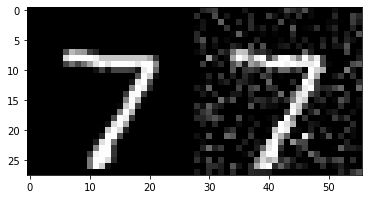

In [68]:
plt.imshow(compare,'gray')
plt.savefig("Compare.svg", dpi=300)

In [ ]:
noise_paired = PairedDataset(noise_imgs, test_labels)
noise_iter = DataLoader(noise_paired, batch_size=batch_size_test, drop_last=True)

In [ ]:
fpr, tpr, thresh = roc_curve(labels, similarity)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.title('ROC_60000_10000_12000')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr,tpr, label=u'AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.savefig("ROC.svg", dpi=300)
plt.show()

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(test_imgs[0],'gray')
plt.subplot(1,2,2)
plt.imshow(noise_imgs[0],'gray')
plt.savefig("noise_compare.svg", dpi=300)
print(test_labels[0])
plt.show()

In [ ]:
noise_simi, noise_example, noise_labels = calculate_simi(model, rc, noise_iter, Wout, device)

In [ ]:
xn = np.round(noise_simi[0:10].detach().numpy(),3)

tensor([0.6346, 0.9140, 0.3691, 0.2519, 0.4204, 0.3937, 0.7499, 0.6650, 0.4418,
        0.4866])


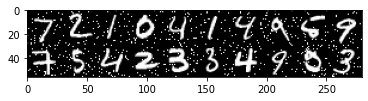

In [90]:
plt.figure()
plt.imshow(noise_example,'gray')
plt.title("Noise var=0.5")
plt.xticks(range(0, 280, 28), x)
x_major_locator = plt.MultipleLocator(28)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.savefig("noiseExample_images.svg", dpi=300)
plt.show()

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

In [84]:
noise_example_pil = Image.fromarray(np.uint8(cv2.normalize(noise_example.detach().numpy(), None, 0, 255, cv2.NORM_MINMAX)))
noise_example_pil.save("noise_example.png")